### Extracting data from the JSON files

In [2]:
DATA_SIZE = 1569264
SAMPLE_SIZE = 10000
TRAIN_SIZE = 7000

In [3]:
import numpy as np
import json 
import pandas

business_ratings = { }

for index, line in enumerate(open("data/yelp_academic_dataset_business.json", "r")):
    json_data = json.loads(line)
    rating, bid = json_data["stars"], json_data["business_id"]
    business_ratings[bid] = rating
    
review_list = []
business_index = { }
selected_businesses = set(np.random.choice(business_ratings.keys(), replace=False, size=SAMPLE_SIZE))
for index, bid in enumerate(selected_businesses):
    review_list.append([bid, business_ratings[bid], ""])
    business_index[bid] = index

for line in open("data/yelp_academic_dataset_review.json", "r"):
    json_data = json.loads(line)
    bid = json_data["business_id"]
    if bid in selected_businesses:
        review_list[business_index[bid]][2] += (json_data["text"] + "\n")
               
review_pd = pandas.DataFrame(review_list, columns = ["Business ID", "Business Rating", "Review Text"])

In [4]:
review_pd.head()

,Business ID,Business Rating,Review Text
0,OlpyplEJ_c_hFxyand_Wxw,3.5,I drove to Inchins on their very first day and...
1,yDnRf8m_YI4AXHVGH6-fuQ,4.0,Sur La Table ...you sexy thing. You with your ...
2,d5NCb9EFgsE4oPlnSXdIgg,2.0,Yum. Very healthy and fresh. The potstickers w...
3,dbMpGh4p9dTxSn5lDSKE3w,3.5,"Good food nice ambience, strong coffee and a g..."
4,FFdlPSZCGgTdg1CAfrlvlw,3.5,Very nice location! A little higher class tha...


### Tokenizing the review text

In [5]:
import sys
import string
import unicodedata

tbl = dict.fromkeys(i for i in xrange(sys.maxunicode) if unicodedata.category(unichr(i)).startswith('P'))

def tokenize(text):
    return unicode(text).translate(tbl).lower().split()

review_pd["Tokenized Text"] = review_pd["Review Text"].apply(tokenize)

In [6]:
review_pd.head()

,Business ID,Business Rating,Review Text,Tokenized Text
0,OlpyplEJ_c_hFxyand_Wxw,3.5,I drove to Inchins on their very first day and...,"[i, drove, to, inchins, on, their, very, first..."
1,yDnRf8m_YI4AXHVGH6-fuQ,4.0,Sur La Table ...you sexy thing. You with your ...,"[sur, la, table, you, sexy, thing, you, with, ..."
2,d5NCb9EFgsE4oPlnSXdIgg,2.0,Yum. Very healthy and fresh. The potstickers w...,"[yum, very, healthy, and, fresh, the, potstick..."
3,dbMpGh4p9dTxSn5lDSKE3w,3.5,"Good food nice ambience, strong coffee and a g...","[good, food, nice, ambience, strong, coffee, a..."
4,FFdlPSZCGgTdg1CAfrlvlw,3.5,Very nice location! A little higher class tha...,"[very, nice, location, a, little, higher, clas..."


In [7]:
review_pd.shape

(10000, 4)

### Manipulating data into LabeledSentences

In [8]:
from gensim.models.doc2vec import LabeledSentence
import numpy as np

class LabeledSentences:
    
    def __init__(self, series):
        self.series = series
        
    def __iter__(self):
        indexes = list(np.arange(len(self.series)))
        np.random.shuffle(indexes)
        for (index, wordlist) in self.series.iloc[indexes].iteritems():
            yield LabeledSentence(words = wordlist, tags = ['VEC_%s' % index])
            
sentences = LabeledSentences(review_pd["Tokenized Text"].copy())

### Learn vector representations for each word via Word2Vec

In [9]:
import multiprocessing
import gensim
from gensim.models import Doc2Vec

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be slow otherwise"
cores = multiprocessing.cpu_count()

model = Doc2Vec(dm = 1, dm_concat = 0, min_count = 1, window = 10, size = 100, sample = 1e-4, negative = 5, 
                workers = cores, alpha = 0.025, min_alpha = 0.025)
model.build_vocab(sentences)

### Learn vector representations for each review text via Doc2Vec

In [10]:
for epoch in range(10):
    model.train(sentences)

### Concatenate Review Rating with Vector

In [20]:
design_matrix, labels = [], []
test_matrix, t_labels = [], []

train_indices = set(np.random.choice(np.arange(len(model.docvecs)), replace=False, size=TRAIN_SIZE))
for index in xrange(len(model.docvecs)):
    key = ("VEC_%s") % (index)
    if index in train_indices:
        design_matrix.append(model.docvecs[key])
        labels.append(review_pd["Business Rating"][index])
    else:
        test_matrix.append(model.docvecs[key])
        t_labels.append(review_pd["Business Rating"][index])
    
design_matrix = np.array(design_matrix)
labels = np.array(labels)

test_matrix = np.array(test_matrix)
t_labels = np.array(t_labels)

(array([    0.,     0.,    62.,    98.,   288.,   608.,   945.,  1495.,
         1519.,  1117.,   868.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5]),
 <a list of 11 Patch objects>)

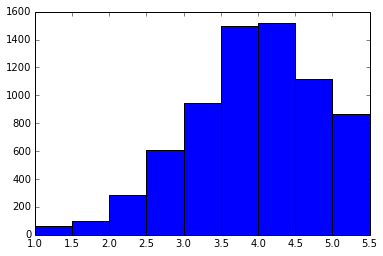

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(labels,bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5])

In [16]:
labels_binary = (labels >= 4).astype(int)
t_labels_binary = (t_labels >= 4).astype(int)

In [17]:
t_labels_binary.sum() * 1.0 / len(t_labels_binary)

0.48966666666666664

### Input data into Binomial Model

In [18]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met

logreg = LogisticRegression()
logreg.fit(design_matrix, labels_binary)

preds = logreg.predict(test_matrix)
print met.accuracy_score(t_labels_binary, preds)

0.822333333333


In [101]:

met.confusion_matrix(t_labels_binary, preds)

array([[2278, 2350],
       [1632, 7215]])

In [102]:
met.precision_score(t_labels_binary, preds)

0.75431259801359118

In [103]:
met.recall_score(t_labels_binary, preds)

0.81553068836893861

### Param tuning

In [118]:
s = 30
step = 20
accus = []

train_indices = set(np.random.choice(np.arange(len(model.docvecs)), replace=False, size=40000))

while s < 130:
    print "training: size = %s" % s 
    cores = multiprocessing.cpu_count()

    model = Doc2Vec(min_count = 1, window = 10, size = s, sample = 1e-4, negative = 5, 
                    workers = cores, alpha = 0.025, min_alpha = 0.025)
    model.build_vocab(sentences)

    for epoch in range(10):
        model.train(sentences)
        model.alpha -= 0.002
        model.min_alpha = model.alpha

    design_matrix, labels = [], []
    test_matrix, t_labels = [], []

    for index in xrange(len(model.docvecs)):
        key = ("VEC_%s") % (index)
        if index in train_indices:
            design_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
            labels.append(business_ratings[review_pd["Business ID"][index]])
        else:
            test_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
            t_labels.append(business_ratings[review_pd["Business ID"][index]])

    design_matrix = np.array(design_matrix)
    labels = np.array(labels)
    #labels = (np.array(labels) > 3).astype(int)

    test_matrix = np.array(test_matrix)
    t_labels = np.array(t_labels)

    labels_binary = (labels >= 4).astype(int)
    t_labels_binary = (t_labels >= 4).astype(int)

    logreg = LogisticRegression()
    logreg.fit(design_matrix, labels_binary)

    preds = logreg.predict(test_matrix)
    accus.append(met.accuracy_score(t_labels_binary, preds))
    print accus[-1]
    s += step
    


training: size = 30
0.701966604824


training: size = 50
0.702486085343


training: size = 70
0.703599257885


training: size = 90
0.703821892393


training: size = 110


KeyboardInterrupt: 

In [123]:
model.docvecs.most_similar('VEC_5')

[('VEC_47637', 0.6760912537574768),
 ('VEC_48227', 0.666786253452301),
 ('VEC_42139', 0.6661235690116882),
 ('VEC_47647', 0.6568830609321594),
 ('VEC_738', 0.6548501253128052),
 ('VEC_52928', 0.65069180727005),
 ('VEC_40785', 0.6479958891868591),
 ('VEC_565', 0.6439300775527954),
 ('VEC_49044', 0.6413969397544861),
 ('VEC_46103', 0.6406590342521667)]

In [124]:
model.most_similar('busy')

[(u'crowded', 0.8520125150680542),
 (u'packed', 0.7235625982284546),
 (u'slow', 0.6773489117622375),
 (u'understaffed', 0.5977272987365723),
 (u'slammed', 0.5810332894325256),
 (u'frustrating', 0.564176082611084),
 (u'noisy', 0.5587003827095032),
 (u'hectic', 0.5579935312271118),
 (u'weekends', 0.5554574131965637),
 (u'weekday', 0.5552082061767578)]

In [127]:
model.most_similar('service')

[(u'food', 0.7933750152587891),
 (u'atmosphere', 0.7314239740371704),
 (u'very', 0.7101171016693115),
 (u'customer', 0.6876224279403687),
 (u'ambiance', 0.687616765499115),
 (u'staff', 0.6858504414558411),
 (u'excellent', 0.681178867816925),
 (u'overall', 0.6800183057785034),
 (u'ambience', 0.6695178151130676),
 (u'consistently', 0.6591460108757019)]

### Input data into Multiclass Logistic Regression Model

In [22]:
design_matrix, labels = [], []
test_matrix, t_labels = [], []

star_mapping = { }
for index in xrange(0, 9):
    star_mapping[index * 0.5 + 1] = index

train_indices = set(np.random.choice(np.arange(len(model.docvecs)), replace=False, size=TRAIN_SIZE))
for index in xrange(len(model.docvecs)):
    key = ("VEC_%s") % (index)
    if index in train_indices:
        design_matrix.append(model.docvecs[key])
        labels.append(star_mapping[review_pd["Business Rating"][index]])
    else:
        test_matrix.append(model.docvecs[key])
        t_labels.append(star_mapping[review_pd["Business Rating"][index]])
    
design_matrix = np.array(design_matrix)
labels = np.array(labels).astype(int)

test_matrix = np.array(test_matrix)
t_labels = np.array(t_labels).astype(int)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

logreg = LogisticRegression(multi_class = "multinomial", solver = "lbfgs")
logreg.fit(design_matrix, labels)

preds = logreg.predict(test_matrix)
print met.accuracy_score(t_labels, preds)
print mean_squared_error(preds, t_labels) ** 0.5

0.406333333333
1.27736708376


(array([   62.,    72.,    93.,   316.,   882.,  1276.,  2403.,  1862.,
         1018.]),
 array([ 0.        ,  0.88888889,  1.77777778,  2.66666667,  3.55555556,
         4.44444444,  5.33333333,  6.22222222,  7.11111111,  8.        ]),
 <a list of 9 Patch objects>)

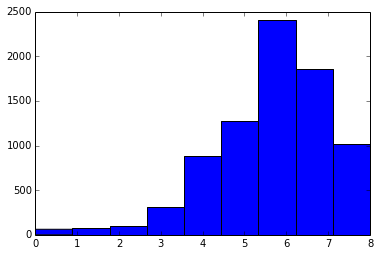

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(t_labels, bins = 9)

In [79]:
stars = np.array(business_ratings.values())
(stars == 3).sum()

8335